## *Import packages*

In [3]:
import requests
from requests.exceptions import ConnectionError,HTTPError
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter

In [4]:
variable = 'all'

In [5]:
url = f'https://restcountries.com/v3.1/{variable}'

In [6]:
#extracting the API request with error handling, non 2xx server responses
try:
    r = requests.get(url,headers={'accept':'application/json'})
    r.raise_for_status()
    response = r.json()
except ConnectionError:
    print("Connection error")
except HTTPError as http_err:
    print(f"Error HTTP: {http_err}")

In [7]:
df = pd.DataFrame(response)

## Exploratory analysis

In [9]:
print(df.columns)

Index(['name', 'tld', 'cca2', 'ccn3', 'cioc', 'independent', 'status',
       'unMember', 'currencies', 'idd', 'capital', 'altSpellings', 'region',
       'subregion', 'languages', 'latlng', 'landlocked', 'borders', 'area',
       'demonyms', 'cca3', 'translations', 'flag', 'maps', 'population',
       'fifa', 'car', 'timezones', 'continents', 'flags', 'coatOfArms',
       'startOfWeek', 'capitalInfo', 'postalCode', 'gini'],
      dtype='object')


In [10]:
print(df.head(3))

                                                name    tld cca2 ccn3 cioc  \
0  {'common': 'Eritrea', 'official': 'State of Er...  [.er]   ER  232  ERI   
1  {'common': 'Cameroon', 'official': 'Republic o...  [.cm]   CM  120  CMR   
2  {'common': 'Montenegro', 'official': 'Monteneg...  [.me]   ME  499  MNE   

   independent               status  unMember  \
0         True  officially-assigned      True   
1         True  officially-assigned      True   
2         True  officially-assigned      True   

                                          currencies  \
0  {'ERN': {'symbol': 'Nfk', 'name': 'Eritrean na...   
1  {'XAF': {'symbol': 'Fr', 'name': 'Central Afri...   
2           {'EUR': {'symbol': '€', 'name': 'Euro'}}   

                                  idd  ... fifa  \
0  {'root': '+2', 'suffixes': ['91']}  ...  ERI   
1  {'root': '+2', 'suffixes': ['37']}  ...  CMR   
2  {'root': '+3', 'suffixes': ['82']}  ...  MNE   

                                   car    timezones continen

In [11]:
#transforming dicts
df['official'] = df['name'].apply(lambda x: x['official'])
df['common'] = df['name'].apply(lambda x: x['common'])
df['capital'] = df['capital'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
df['languages'] = df['languages'].apply(lambda x: ', '.join(x.values()) if isinstance(x, dict) else None)
df['name']
df['independent']
df['currency_name'] = df['currencies'].apply(lambda x: ', '.join([v['name'] for v in x.values()]) if isinstance(x, dict) else None)
df['flags'] = df['flags'].apply(lambda x:x['png'])

In [12]:
#creating a data frame with columns of interest
df_arranged = df[['official', 'common', 'capital', 'languages','region','subregion','independent','currency_name','area','population','flags',]].copy()

In [13]:
df_arranged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   official       250 non-null    object 
 1   common         250 non-null    object 
 2   capital        246 non-null    object 
 3   languages      249 non-null    object 
 4   region         250 non-null    object 
 5   subregion      245 non-null    object 
 6   independent    250 non-null    bool   
 7   currency_name  247 non-null    object 
 8   area           250 non-null    float64
 9   population     250 non-null    int64  
 10  flags          250 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 19.9+ KB


In [14]:
#checking missing values
df_arranged.isna().sum()

official         0
common           0
capital          4
languages        1
region           0
subregion        5
independent      0
currency_name    3
area             0
population       0
flags            0
dtype: int64

In [15]:
#checking what criteria to use to fill in missing values
df_arranged[df_arranged[['capital', 'languages','subregion','currency_name']].isna().any(axis=1)]

,official,common,capital,languages,region,subregion,independent,currency_name,area,population,flags
6,South Georgia and the South Sandwich Islands,South Georgia,King Edward Point,English,Antarctic,NaN,False,British pound,3903.0,30,https://flagcdn.com/w320/gs.png
40,Territory of the French Southern and Antarctic...,French Southern and Antarctic Lands,Port-aux-Français,French,Antarctic,NaN,False,Euro,7747.0,400,https://flagcdn.com/w320/tf.png
94,Macao Special Administrative Region of the Peo...,Macau,None,"Portuguese, Chinese",Asia,Eastern Asia,False,Macanese pataca,30.0,649342,https://flagcdn.com/w320/mo.png
100,Bouvet Island,Bouvet Island,None,Norwegian,Antarctic,NaN,False,None,49.0,0,https://flagcdn.com/w320/bv.png
101,Antarctica,Antarctica,None,None,Antarctic,NaN,False,None,14000000.0,1000,https://flagcdn.com/w320/aq.png
236,Heard Island and McDonald Islands,Heard Island and McDonald Islands,None,English,Antarctic,NaN,False,None,412.0,0,https://flagcdn.com/w320/hm.png


In [16]:
#filling missing values
df_arranged['capital'] = df_arranged['capital'].fillna(df_arranged['common'])
df_arranged['subregion'] = df_arranged['subregion'].fillna(df_arranged['region'])
df_arranged['languages'] = df_arranged['languages'].fillna('unknown')
df_arranged['currency_name'] = df_arranged['currency_name'].fillna('unknown')

In [17]:
df_arranged.isna().sum()

official         0
common           0
capital          0
languages        0
region           0
subregion        0
independent      0
currency_name    0
area             0
population       0
flags            0
dtype: int64

## *Data manipulation and analysis*
### *Getting some insights*

##### Country distribution by region and subregion - Wich region has more countries quantity?

In [20]:
countries_by_region = df_arranged.groupby('region')['common'].count().sort_values(ascending=False)

In [21]:
region_df = countries_by_region.reset_index()
region_df.columns = ['region', 'country_count']

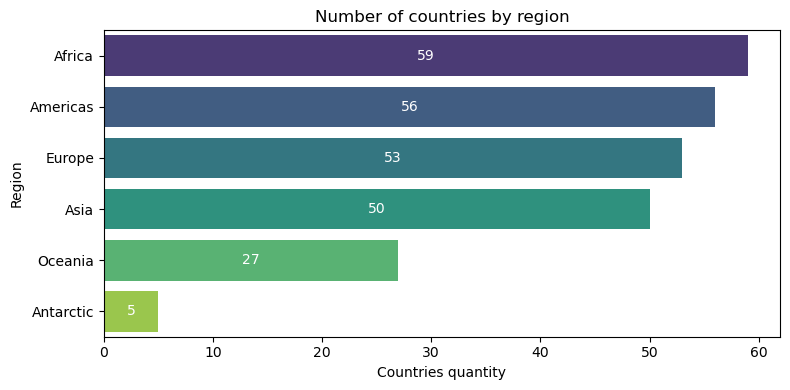

In [22]:
#The following graph shows the number of countries by region
plt.figure(figsize=(8,4))
ax = sns.barplot(data=region_df, x='country_count', y='region',hue='region', palette='viridis')
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=10)
plt.title('Number of countries by region')
plt.xlabel('Countries quantity')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

In [23]:
countries_by_subregion = df_arranged.groupby('subregion')['common'].count().sort_values(ascending=False)

In [24]:
subregion_df = countries_by_subregion.reset_index()
subregion_df.columns = ['subregion', 'country_count']

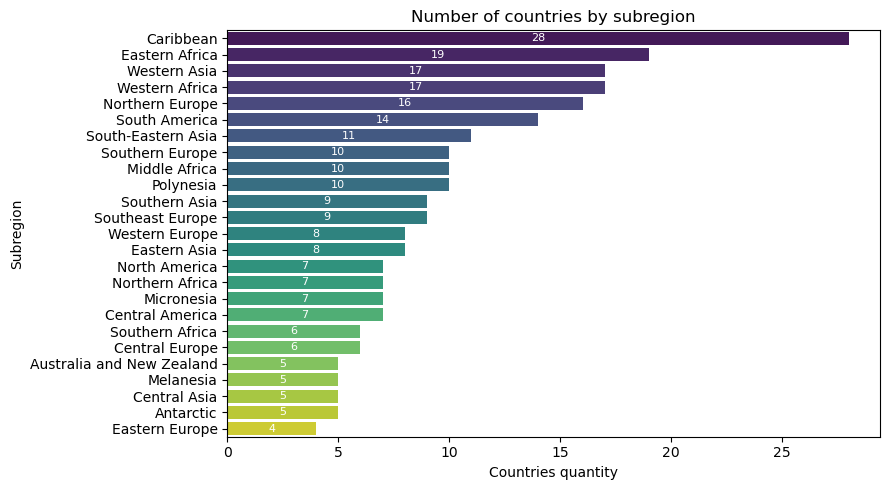

In [25]:
#The following graph shows the number of countries by subregion
plt.figure(figsize=(9,5))
ax = sns.barplot(data=subregion_df, x='country_count', y='subregion',hue='subregion', palette='viridis')
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='white', fontsize=8)
plt.title('Number of countries by subregion')
plt.xlabel('Countries quantity')
plt.ylabel('Subregion')
plt.tight_layout()
plt.show()

#### *Top countries by population and area*

In [27]:
df_population = df_arranged[['population','common']].sort_values('population',ascending=False).head(10)

In [28]:
df_population

,population,common
129,1402112000,China
115,1380004385,India
102,329484123,United States
91,273523621,Indonesia
145,220892331,Pakistan
7,212559409,Brazil
114,206139587,Nigeria
171,164689383,Bangladesh
225,144104080,Russia
9,128932753,Mexico


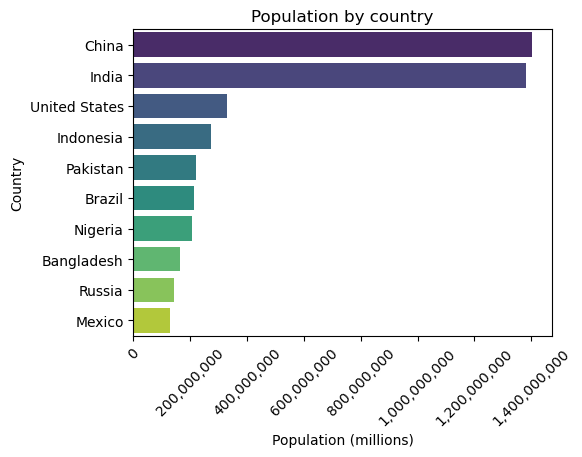

In [29]:
#The following graph shows the top 10 country population
plt.figure(figsize=(6,4))
ax1=sns.barplot(x='population',y='common',data=df_population,hue='common',palette='viridis')
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title('Population by country')
plt.xlabel('Population (millions)')
plt.ylabel('Country')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [30]:
df_area = df_arranged[['area','common']].sort_values('area',ascending=False).head(10)

In [31]:
df_area.head(3)

,area,common
225,17098242.0,Russia
101,14000000.0,Antarctica
161,9984670.0,Canada


In [32]:
#Antarctica is removed here because it is not a country
df_area = df_area.drop(df_area[df_area['common']=='Antarctica'].index)

In [33]:
df_area

,area,common
225,17098242.0,Russia
161,9984670.0,Canada
129,9706961.0,China
102,9372610.0,United States
7,8515767.0,Brazil
194,7692024.0,Australia
115,3287590.0,India
146,2780400.0,Argentina
64,2724900.0,Kazakhstan


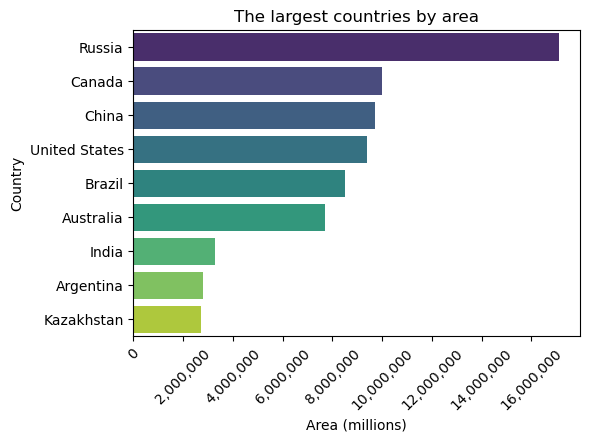

In [34]:
#The following graph shows the top 10 country by area
plt.figure(figsize=(6,4))
ax2 = sns.barplot(x='area', y='common', data=df_area, hue='common', palette='viridis')
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title('The largest countries by area')
plt.xlabel('Area (millions)')
plt.ylabel('Country')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### *Most densities countries*

In [36]:
#A 'density' column is added, which is the division of the population over the area.
df_arranged['density']= df_arranged['population'] / df_arranged['area']

In [37]:
df_density = df_arranged[['density','common']].sort_values('density',ascending=False).head(5)

In [38]:
df_density

,density,common
94,21644.733333,Macau
209,19427.722772,Monaco
138,8008.178873,Singapore
128,6794.112319,Hong Kong
153,5615.166667,Gibraltar


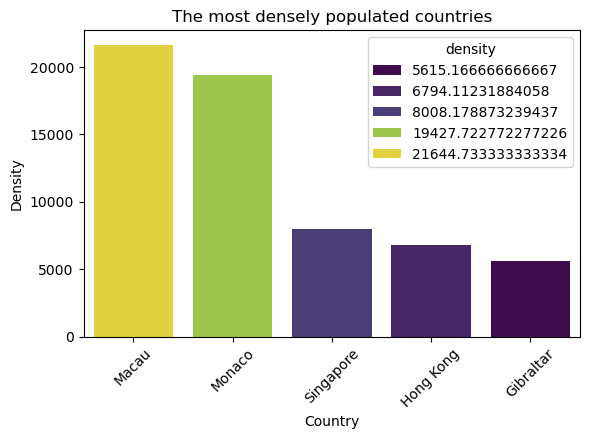

In [39]:
#The following graph shows the top 5 country density
plt.figure(figsize=(6,4))
ax2 = sns.barplot(x='common', y='density', data=df_density, hue='density', palette='viridis')
plt.title('The most densely populated countries')
plt.xlabel('Country')
plt.ylabel('Density')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#### *Correlation area vs population*

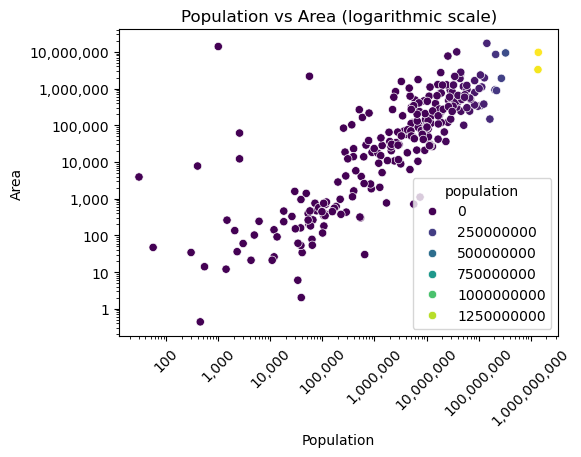

In [41]:
#The following graph shows whether there is a relationship between the area of a country and its population.
plt.figure(figsize=(6,4))
ax3 = sns.scatterplot(data=df_arranged, x='population', y='area',hue='population',palette='viridis')
ax3.set(xscale='log', yscale='log')

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax3.xaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)

plt.title('Population vs Area (logarithmic scale)')
plt.xlabel('Population')
plt.ylabel('Area')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

As can be seen, there is a relationship between the number of inhabitants of a country and its area size.

#### *Most spoken languages in different countries*

In [44]:
df_languages = (df_arranged.groupby('languages')['common'].count().sort_values(ascending=False).head().reset_index(name='count'))
df_languages

,languages,count
0,English,39
1,French,23
2,Arabic,15
3,Spanish,14
4,Portuguese,6


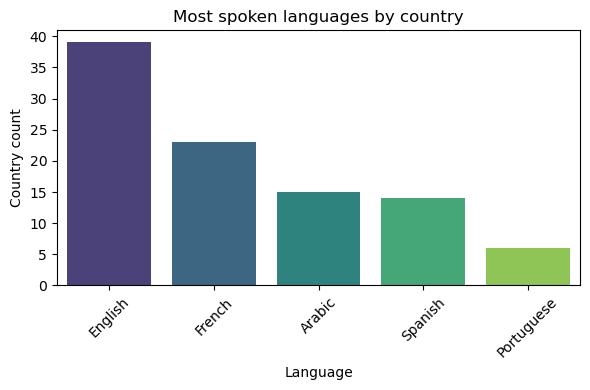

In [45]:
plt.figure(figsize=(6,4))
sns.barplot(data=df_languages, x='languages', y='count',hue='languages', palette='viridis')
plt.xticks(rotation=45)
plt.title('Most spoken languages ​​by country')
plt.xlabel('Language')
plt.ylabel('Country count')
plt.tight_layout()
plt.show()

#### *What is the most spoken language, in terms of the number of speakers?*

In [47]:
df_languages_by_pop = (df_arranged.groupby('languages')['population'].sum().sort_values(ascending=False).head().reset_index(name='quantity'))
df_languages_by_pop

,languages,quantity
0,Chinese,1425615349
1,"English, Hindi, Tamil",1380004385
2,English,709345464
3,Spanish,319941674
4,Arabic,291371097


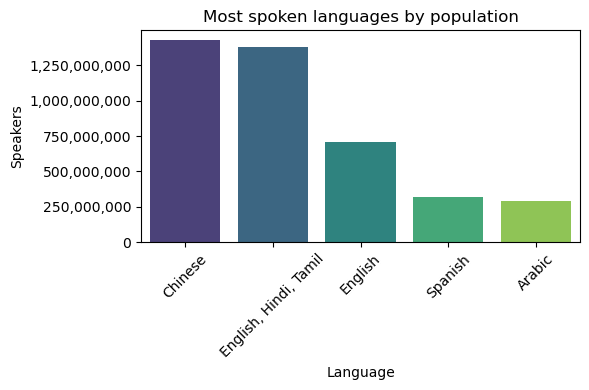

In [48]:
plt.figure(figsize=(6,4))
ax4=sns.barplot(data=df_languages_by_pop, x='languages', y='quantity',hue='languages', palette='viridis')
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=45)
plt.title('Most spoken languages by population')
plt.xlabel('Language')
plt.ylabel('Speakers')
plt.tight_layout()
plt.show()

#### *Independent and dependent countries*

In [50]:
df_independent = df_arranged['independent'].value_counts()

In [51]:
df_independent

independent
True     195
False     55
Name: count, dtype: int64

In [52]:
labels = ['Independent', 'Dependent']
sizes = [195, 55]  # o 250-55 y 55

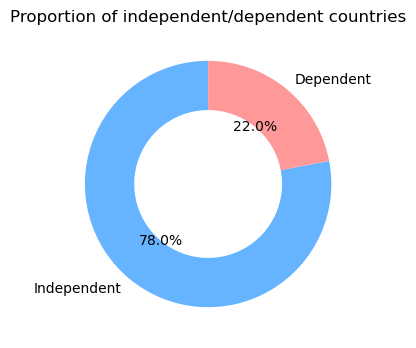

In [53]:
plt.figure(figsize=(6,4))
colors = ['#66b3ff','#ff9999']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,colors=colors, wedgeprops=dict(width=0.4))
plt.title('Proportion of independent/dependent countries')
plt.show()